In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import clear_output
%matplotlib inline

In [2]:
#Setting random seed to get same results across runs
np.random.seed(321)

In [11]:
#Setting data paths
data_path = "dataset/"
#Path to save data after preprocessing
results_imdb_path = os.path.join(data_path, "results/imdb/")
#Models reults path
results_models = os.path.join(data_path, "results/")

In [12]:
if not os.path.isdir(data_path):
    os.mkdir(data_path)
if not os.path.isdir(results_imdb_path):
    os.makedirs(results_imdb_path)
if not os.path.isdir(results_models):
    os.makedirs(results_models)

In [13]:
def accuracy(preds, labels):
    pred = np.argmax(preds, axis=1).flatten()
    labels= labels.flatten()
    return np.sum(pred == labels) / len(labels)

# 1: Data Processing 

### (a) Input the datasets: 

In [ ]:
%pip install -q datasets

In [ ]:
from datasets import load_dataset
dataset_train, dataset_test = load_dataset('imdb', split=['train', 'test'])

In [ ]:
print("The length of reviews in the training set is: " ,len(dataset_train))

In [ ]:
print("The length of reviews in the testing set is: " ,len(dataset_test))

In [ ]:
# store the csv to data.frame:
train_df=pd.DataFrame(dataset_train)
train_df

In [ ]:
test_df=pd.DataFrame(dataset_test)

In [ ]:
# checking the balance of labels in the training set: 
height = [list(train_df['label']).count(0), list(train_df['label']).count(1)]
bars = ('0 (Neg)', '1 (Pos)')
y_pos = np.arange(len(bars))
plt.bar(y_pos, height)
plt.xticks(y_pos, bars)
plt.ylabel('Count')
plt.xlabel('Labels')
plt.title('Counts of positive and negative labels in training set')
plt.show() # very balanced labels

In [ ]:
# checking the balance of labels in the testing set: 
height = [list(test_df['label']).count(0), list(test_df['label']).count(1)]
bars = ('0 (Neg)', '1 (Pos)')
y_pos = np.arange(len(bars))
plt.bar(y_pos, height)
plt.xticks(y_pos, bars)
plt.ylabel('Count')
plt.xlabel('Labels')
plt.title('Counts of positive and negative labels in testing set')
plt.show() # very balanced labels

In [ ]:
# save the two dataframes
train_df.to_csv(os.path.join(data_path, 'train-df-original.csv'))
test_df.to_csv(os.path.join(data_path, 'test-df-original.csv'))

In [14]:
# To keep working after running previous steps once
train_df = pd.read_csv(os.path.join(data_path, 'test-df-original.csv'))
test_df = pd.read_csv(os.path.join(data_path, 'train-df-original.csv'))
train_df = train_df[["text", "label"]] # make sure we only have these two columns
test_df = test_df[["text", "label"]] # make sure we only have these two columns

In [15]:
train_df_bert = train_df
test_df_bert = test_df

### (b) Further filter out and clean the reviews: 

In [6]:
# A further preprocessing: remove punctuation marks, special marks, non-letters nor digits, etc
# Specifically, we need to get rid of: 
# 1.  punctuation marks
# 2.  HTML/URL tags
# 3.  characters which are neither letters nor digits
# 4.  successive whitespaces
# 5.  Capital letters
# 6.  whitespaces
# 7.  stopwords

In [7]:
import re
import nltk

def deepprocess(x):
    x = re.sub('[,\.!?:()"]', '', x)
    x = re.sub('<.*?>', ' ', x)
    x = re.sub('http\S+', ' ', x)
    x = re.sub('[^a-zA-Z0-9]', ' ', x)
    x = re.sub('\s+', ' ', x)
    return x.lower().strip()

stopword_set = set(nltk.corpus.stopwords.words('english'))
def stopword_remove(x):
    words = nltk.tokenize.word_tokenize(x)
    filtered_list = [word for word in words if word not in stopword_set]
    return ' '.join(filtered_list)


In [8]:
#Only run the first time
#nltk.download('stopwords')
#nltk.download('punkt')


In [9]:
# For the training set: 
import random
# (1) an example before pre-process:
idx = random.randint(0, len(train_df)-1)
before_process = train_df.iloc[idx][0]
print("Before Process: \n", before_process)
# (2) this is how it changed different after removing weird char: 
train_df['text'] = train_df['text'].apply(lambda x: deepprocess(x))
after_process = train_df.iloc[idx][0]
print("\nAfter removing weird char: \n", after_process)

# (3) remove stopwords:
train_df['text'] = train_df['text'].apply(lambda x: stopword_remove(x))
after_process = train_df.iloc[idx][0]
print("\nAfter processing: \n", after_process)


Before Process: 
 If you "been there" and "done that" you will absolutely love this film. I have and by "there" I mean underground clubs and house parties where there is far more rare to find people just being drunk than it is to find people high to their ears on extacy, speed or LSD. <br /><br />By "that" I mean dancing and sweating like crazy for eight hours or so in a row with out even a brake and , that followed by a way to long morning of no-can-sleep and almost wanting to die, followed by a week of just waiting till the next weekend to do it all again.<br /><br />So even though this film now is one of my absolute favourites I can certainly understand why some people, or most people even, would dislike it.

After removing weird char: 
 if you been there and done that you will absolutely love this film i have and by there i mean underground clubs and house parties where there is far more rare to find people just being drunk than it is to find people high to their ears on extacy spe

In [10]:
# For test sets: 
test_df['text'] = test_df['text'].apply(lambda x: deepprocess(x))
test_df['text'] = test_df['text'].apply(lambda x: stopword_remove(x))

In [46]:
# train texts and labels to lists: 
train_txt, train_label= train_df['text'], train_df['label']
test_txt, test_label= test_df['text'], test_df['label']

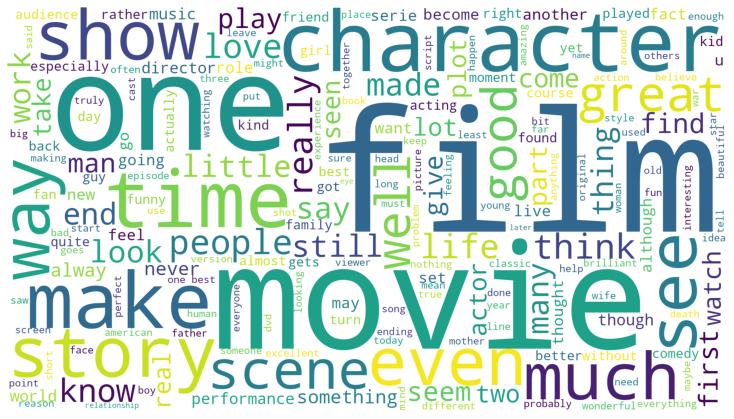

In [12]:
# wordcloud for positive reviews in the training set:
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white",width=1920,height=1080).generate(" ".join(train_df[train_df.label==1].text))
fig = plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)

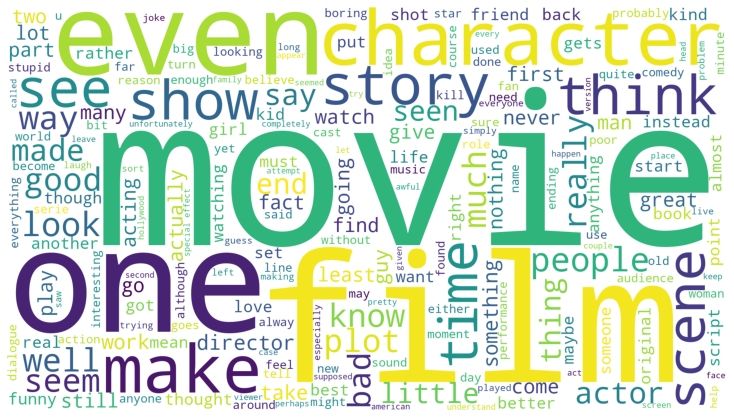

In [13]:
# wordcloud for negative reviews in the training set:
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white",width=1920,height=1080).generate(" ".join(train_df[train_df.label==0].text))
fig = plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)

### (c) Lists and Tokenization

In [14]:
# tokenization: 
from keras.preprocessing.text import Tokenizer

token = Tokenizer()
token.fit_on_texts(train_df['text'])

In [15]:
print('Length of the tokenizer index:' , len(token.word_index))
print('First 20 entries of the tokenizer index:' )
print(*list(token.word_index.items())[:20])

Length of the tokenizer index: 86389
First 20 entries of the tokenizer index:
('movie', 1) ('film', 2) ('one', 3) ('like', 4) ('good', 5) ('time', 6) ('would', 7) ('even', 8) ('see', 9) ('really', 10) ('story', 11) ('well', 12) ('much', 13) ('bad', 14) ('get', 15) ('great', 16) ('people', 17) ('also', 18) ('first', 19) ('make', 20)


In [16]:
# convert the training and test reviews to lists of seq of integers (tokens)
train_txt_tokens = token.texts_to_sequences(train_txt)
test_txt_tokens = token.texts_to_sequences(test_txt)

# Get length of sequences for each review
seq_lens =  np.array([len(sequence) for sequence in train_txt_tokens])

In [17]:
# the length of seq:
import scipy
upper_bound = int(np.mean(seq_lens) + 2 * np.std(seq_lens))
percentage = scipy.stats.percentileofscore(seq_lens, upper_bound)
print('The value of upper_bound is %d and the percentage of sequences in "train_rev_tokens" \
of length smaller or equal than upper_bound is %.2f%%.' % (upper_bound, round(percentage, 2)))

The value of upper_bound is 295 and the percentage of sequences in "train_rev_tokens" of length smaller or equal than upper_bound is 94.53%.


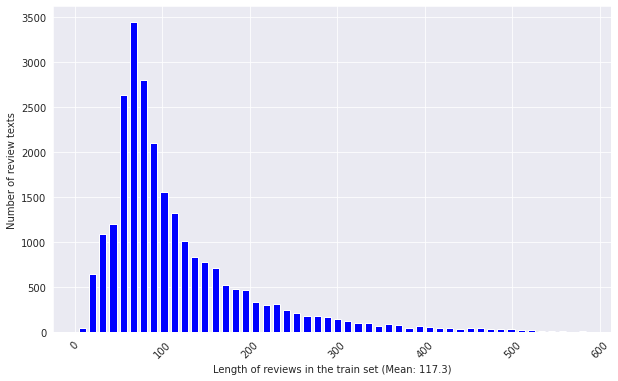

In [18]:
# histogram for the training set: 
#np.mean(seq_lens)
with sns.axes_style("darkgrid"):

    _, hist = plt.subplots(figsize=(10,6))
    hist.hist(seq_lens[seq_lens < 2*upper_bound], color='blue', bins=50, rwidth=0.7)
    plt.xlabel('Length of reviews in the train set (Mean: 117.3)')
    plt.ylabel('Number of review texts')
    plt.xticks(rotation=45)
    plt.show()

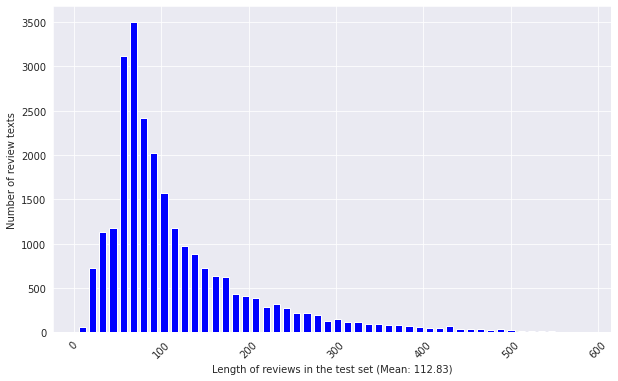

In [19]:
# For the test set, we can also do similar work:
seq_lens_t =  np.array([len(sequence) for sequence in test_txt_tokens])
upper_bound_t = int(np.mean(seq_lens_t) + 2 * np.std(seq_lens_t))
with sns.axes_style("darkgrid"):

    _, hist = plt.subplots(figsize=(10,6))
    hist.hist(seq_lens_t[seq_lens_t < 2*upper_bound_t], color='blue', bins=50, rwidth=0.7)
    plt.xlabel('Length of reviews in the test set (Mean: 112.83)')
    plt.ylabel('Number of review texts')
    plt.xticks(rotation=45)
    plt.show()

Text(0.5, 1.0, 'Negative Reviews length in the training set')

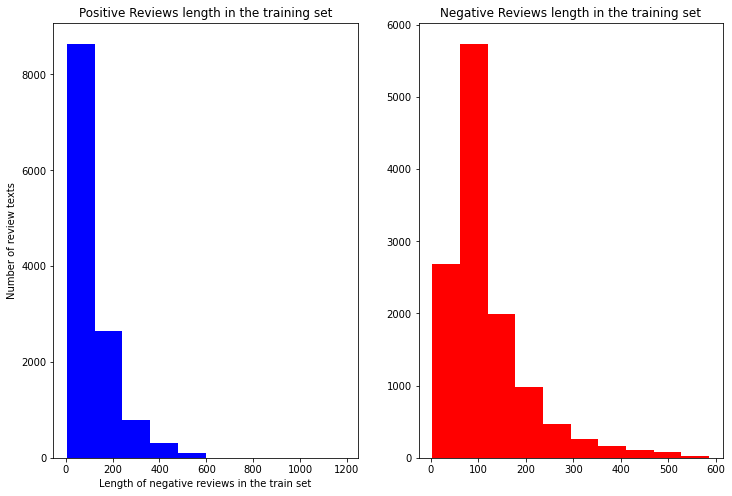

In [20]:
# For the pos and neg reviews in the training set: 
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=train_df[train_df['label']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='blue')
ax1.set_xlabel('Length of positive reviews in the train set')
ax1.set_ylabel('Number of review texts')
ax1.set_title('Positive Reviews length in the training set')

text_len=train_df[train_df['label']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='red')
ax1.set_xlabel('Length of negative reviews in the train set')
ax1.set_ylabel('Number of review texts')
ax2.set_title('Negative Reviews length in the training set')


# 2: Classic Machine Learning Models 
Classification performance for models: LR, SVM, RF, XGBoost

In [21]:
from sklearn import metrics
from nltk.tokenize import word_tokenize
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer

In [23]:
# preparing datasets: tokenized (Tf–idf), short for term frequency–inverse document frequency
vec = TfidfVectorizer(tokenizer = word_tokenize, token_pattern = None)
vec.fit(train_df.text)
X_train_token= vec.transform(train_df.text)
X_test_token = vec.transform(test_df.text)

#### 2.1 LR (with l1-norm and l2-norm regularization)

In [24]:
from sklearn.linear_model import LogisticRegression
logisticReg_l2_mod = LogisticRegression(penalty='l2',random_state=321)# set seeds, l2-norm
logisticReg_l1_mod = LogisticRegression(penalty='l1',random_state=321, solver='liblinear')# set seeds, l1-norm
logisticReg_l2_mod.fit(X_train_token, train_label)
lr_preds_l2_proba = logisticReg_l2_mod.predict_proba(X_test_token)
lr_preds_l2 = lr_preds_l2_proba[:,1:]
logisticReg_l1_mod.fit(X_train_token, train_label)
lr_preds_l1_proba = logisticReg_l1_mod.predict_proba(X_test_token)
lr_preds_l1 = lr_preds_l1_proba[:,1:]

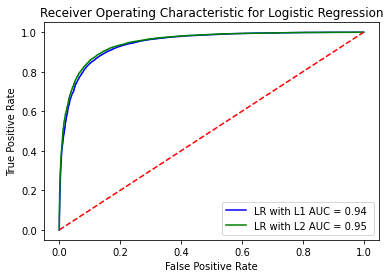

In [25]:
# ROC curve for LR (l1-norm reg and l2-norm reg):
fpr_lr_l1, tpr_lr_l1, _ = metrics.roc_curve(test_label, lr_preds_l1)
fpr_lr_l2, tpr_lr_l2, _ = metrics.roc_curve(test_label, lr_preds_l2)
roc_auc_lr_l1 = metrics.auc(fpr_lr_l1, tpr_lr_l1)
roc_auc_lr_l2 = metrics.auc(fpr_lr_l2, tpr_lr_l2)
plt.title('Receiver Operating Characteristic for Logistic Regression')
plt.plot(fpr_lr_l1, tpr_lr_l1, 'b', label = 'LR with L1 AUC = %0.2f ' % roc_auc_lr_l1)
plt.plot(fpr_lr_l2, tpr_lr_l2, 'g', label = 'LR with L2 AUC = %0.2f ' % roc_auc_lr_l2)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [26]:
#Accuracy 
acc_lr_l2 = accuracy(lr_preds_l2_proba, np.array(test_label))
acc_lr_l1 = accuracy(lr_preds_l1_proba, np.array(test_label))

#### 2.2 RF

In [28]:
from sklearn.ensemble import RandomForestClassifier
RF_mod = RandomForestClassifier(random_state=36)
RF_mod.fit(X_train_token, train_label)
RF_pred_proba = RF_mod.predict_proba(X_test_token)

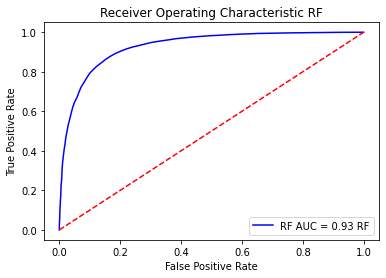

In [32]:
RF_pred = RF_pred_proba[:,1:]
fpr_RF, tpr_RF, _ = metrics.roc_curve(test_label, RF_pred)
roc_RF = metrics.auc(fpr_RF, tpr_RF)
plt.title('Receiver Operating Characteristic RF')
plt.plot(fpr_RF, tpr_RF, 'b', label = 'RF AUC = %0.2f RF' % roc_RF)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [35]:
acc_rf = accuracy(RF_pred_proba, np.array(test_label))

<AxesSubplot:>

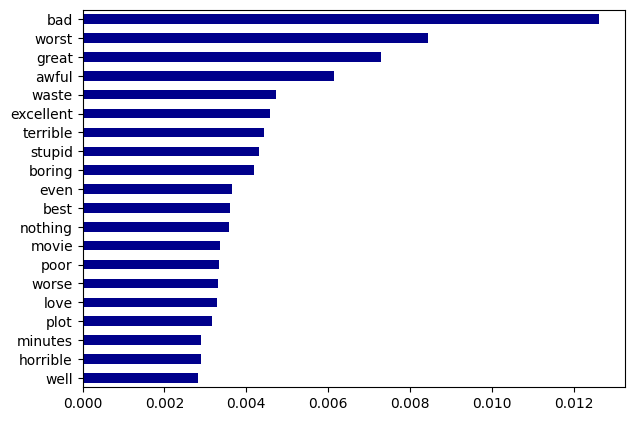

In [110]:
# Create a DataFrame
df2 = pd.DataFrame(X_train_token.toarray(), columns=vec.get_feature_names_out())
df2['y'] = train_df.label

importances_rf = pd.Series(RF_mod.feature_importances_, index=df2.columns[:-1])
sorted_importances_rf = importances_rf.sort_values()[-20:]
sorted_importances_rf.plot(kind='barh', color='darkblue')

#### XGBoost

In [30]:
import xgboost as xgb
xgb_mod = xgb.XGBClassifier(max_depth = 8, eta = 0.7, objective= 'binary:logistic', 
                              n_estimators = 200,  eval_metric = 'auc')
xgb_mod.fit(X_train_token, train_label)
xgb_preds_proba = xgb_mod.predict_proba(X_test_token)

/home/hamza97/venv/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


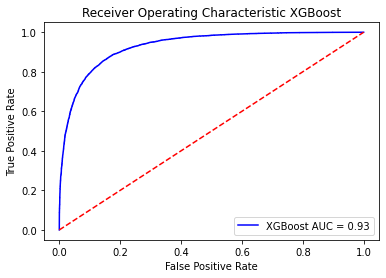

In [34]:
# ROC curve for XGBoost:
xgb_preds = xgb_preds_proba[:,1:]
fpr_xgb, tpr_xgb, _ = metrics.roc_curve(test_label, xgb_preds)
roc_auc_xgb = metrics.auc(fpr_xgb, tpr_xgb)
plt.title('Receiver Operating Characteristic XGBoost')
plt.plot(fpr_xgb, tpr_xgb, 'b', label = 'XGBoost AUC = %0.2f' % roc_auc_xgb)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [36]:
acc_xgboost = accuracy(xgb_preds_proba, np.array(test_label))

# BERT

In [3]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn.utils import clip_grad_norm_


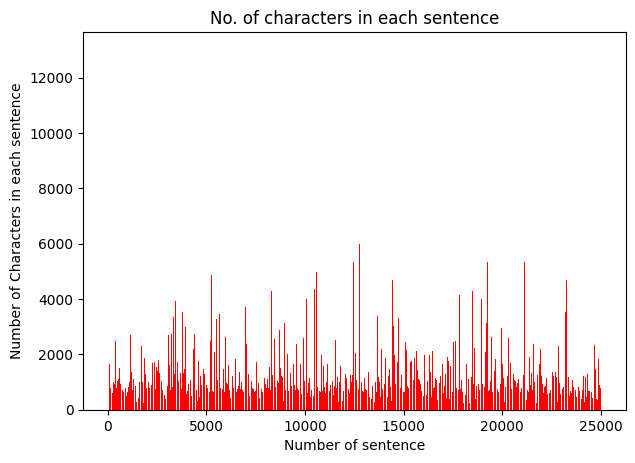

In [16]:
train_data = train_df_bert.to_dict(orient='records')
test_data = test_df_bert.to_dict(orient='records')

# Mapping sentences with their Labels
train_texts, train_labels = list(zip(*map(lambda d: (d['text'], d['label']), train_data)))
test_texts, test_labels = list(zip(*map(lambda d: (d['text'], d['label']), test_data)))

# visualizing sentences lengths
sentences = [len(sent) for sent in train_texts]

plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})
plt.bar(range(1,25001), sentences, color = ['red'])
plt.gca().set(title='No. of characters in each sentence', xlabel='Number of sentence', ylabel='Number of Characters in each sentence');


In [17]:
# Preparing toke
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [18]:
def get_ids_and_masks(texts, max_length = 510, pad_to_max_length = True, add_special_tokens=True,):
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in texts:
        # `encode_plus` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = tokenizer.encode_plus(
                            sent,                      # Sentence to encode.
                            add_special_tokens = add_special_tokens, # Add '[CLS]' and '[SEP]'
                            max_length = max_length,           # Pad & truncate all sentences.
                            pad_to_max_length = pad_to_max_length,
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                    )
        
        # Add the encoded sentence to the list.    
        input_ids.append(encoded_dict['input_ids'])
        
        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])
    return input_ids, attention_masks

In [19]:
max_length = 510
#train data processing:
train_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:max_length] + ['[SEP]'], train_texts))
train_tokens_ids, train_masks = get_ids_and_masks(train_texts)
#test data processing:
test_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:max_length] + ['[SEP]'], test_texts))
test_tokens_ids, test_masks = get_ids_and_masks(test_texts)



Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/hamza97/venv/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [20]:
train_y = np.array(train_labels) 
test_y = np.array(test_labels)


In [21]:
#transform into tensors
#train
train_tokens_ids_tensor = torch.Tensor(25000, max_length)
torch.cat(train_tokens_ids, out=train_tokens_ids_tensor)
train_masks_tensor = torch.Tensor(25000, max_length)
torch.cat(train_masks, out=train_masks_tensor)
train_y = torch.tensor(train_y.reshape(-1, 1)).float()
del train_tokens_ids, train_masks
#test
test_tokens_ids_tensor = torch.Tensor(25000, max_length)
torch.cat(test_tokens_ids, out=test_tokens_ids_tensor)
test_masks_tensor = torch.Tensor(25000, max_length)
torch.cat(test_masks, out=test_masks_tensor)
test_y = torch.tensor(test_y.reshape(-1, 1)).float()
del test_tokens_ids, test_masks


In [22]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
train_data = TensorDataset(train_tokens_ids_tensor, train_masks_tensor, train_y)
test_data = TensorDataset(test_tokens_ids_tensor, test_masks_tensor, test_y)

# divide train into 80% train and 20% valid
train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
test_size = len(test_data)
# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(train_data, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))
print('{:>5,} test samples'.format(test_size))


20,000 training samples
5,000 validation samples
25,000 test samples


In [16]:

batch_size = 32
train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size 
        )

validation_dataloader = DataLoader(
            val_dataset, 
            sampler = SequentialSampler(val_dataset), 
            batch_size = batch_size
        )

test_dataloader = DataLoader(
            test_data, 
            sampler = SequentialSampler(test_data), 
            batch_size = batch_size
        )


In [17]:
torch.cuda.empty_cache()   # Clearing Cache space for a fresh Model run

In [4]:

# Load BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", 
    num_labels = 2, 
    output_attentions = False, 
    output_hidden_states = False,
)

model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [19]:
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

In [20]:
from transformers import get_linear_schedule_with_warmup

epochs = 4
steps_per_epoch = len(train_dataloader) 
total_steps = steps_per_epoch * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)


In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [23]:
training_stats = []
for epoch in range(0, epochs):
    total_train_loss = 0
    total_train_accuracy = 0
    model.train()
    for step, batch in enumerate(train_dataloader):
        # Progress update every 100 iteration.
        if (step + 1 + epoch*steps_per_epoch) % 100 == 0 and not step == 0:
            print('  iteration {:>5,}  of  {:>5,}.'.format(step+1 + epoch*steps_per_epoch, total_steps,))
        b_input_ids = batch[0].to(device).long()
        b_input_mask = batch[1].to(device).long()
        b_labels = batch[2].to(device).long()

        model.zero_grad()        
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels,
                            return_dict = False)
        total_train_loss += loss.item()
        total_train_accuracy += accuracy(logits.cpu().detach().numpy(), b_labels.cpu().detach().numpy())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)            
    avg_train_accuracy = total_train_accuracy / len(train_dataloader)
    print("Epoch train  Accuracy: %.2f, Epoch train Loss: %.2f"%(avg_train_accuracy, avg_train_loss))

    model.eval()

    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device).long()
        b_input_mask = batch[1].to(device).long()
        b_labels = batch[2].to(device).long()
        
        with torch.no_grad():        
            loss, logits = model(b_input_ids, 
                                    token_type_ids=None, 
                                    attention_mask=b_input_mask,
                                    labels=b_labels,
                                    return_dict = False)
            
        total_eval_loss += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += accuracy(logits, label_ids)
        

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    avg_val_loss = total_eval_loss / len(validation_dataloader)    
    print("Epoch Validation  Accuracy: %.2f, Epoch Validation Loss: %.2f"%(avg_val_accuracy, avg_val_loss))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch + 1,
            'Training Loss': avg_train_loss,
            'Training Acc': avg_train_accuracy,
            'Validation Loss': avg_val_loss,
            'Validation Acc.': avg_val_accuracy,
        }
    )

  iteration   100  of  2,500.
  iteration   200  of  2,500.
  iteration   300  of  2,500.
  iteration   400  of  2,500.
  iteration   500  of  2,500.
  iteration   600  of  2,500.
Epoch train  Accuracy: 0.90, Epoch train Loss: 0.24
Epoch Validation  Accuracy: 0.93, Epoch Validation Loss: 0.19
  iteration   700  of  2,500.
  iteration   800  of  2,500.
  iteration   900  of  2,500.
  iteration 1,000  of  2,500.
  iteration 1,100  of  2,500.
  iteration 1,200  of  2,500.
Epoch train  Accuracy: 0.96, Epoch train Loss: 0.12
Epoch Validation  Accuracy: 0.93, Epoch Validation Loss: 0.18
  iteration 1,300  of  2,500.
  iteration 1,400  of  2,500.
  iteration 1,500  of  2,500.
  iteration 1,600  of  2,500.
  iteration 1,700  of  2,500.
  iteration 1,800  of  2,500.
Epoch train  Accuracy: 0.98, Epoch train Loss: 0.06
Epoch Validation  Accuracy: 0.94, Epoch Validation Loss: 0.29
  iteration 1,900  of  2,500.
  iteration 2,000  of  2,500.
  iteration 2,100  of  2,500.
  iteration 2,200  of  2,500

In [40]:
#extract stats
Training_Loss, Training_Acc, Validation_Loss, Validation_Acc = [], [], [], []
for stats in training_stats:
    Training_Loss.append(stats["Training Loss"])
    Training_Acc.append(stats["Training Acc"])
    Validation_Loss.append(stats["Validation Loss"])
    Validation_Acc.append(stats["Validation Acc."])

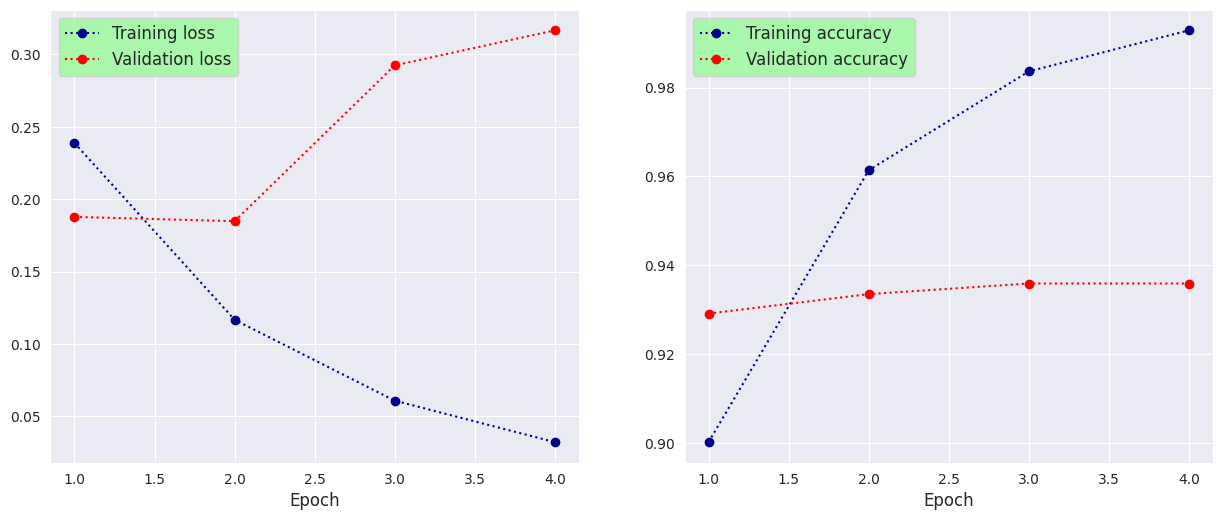

In [42]:
# evaluate the epochs: 
ep_values = range(1, epochs+1)
with sns.axes_style("darkgrid"):

    _, (loss, acc) = plt.subplots(1, 2, figsize=(15, 6))
    loss.plot(ep_values, Training_Loss, color='darkblue', linestyle='dotted',
              marker='o', label='Training loss')
    loss.plot(ep_values, Validation_Loss, color='r', linestyle='dotted',
              marker='o', label='Validation loss')
    loss.set_xlabel('Epoch', size='large')
    loss.legend(fontsize='large', facecolor='palegreen')

    acc.plot(ep_values, Training_Acc, color='darkblue', linestyle='dotted',
             marker='o', label='Training accuracy')
    acc.plot(ep_values, Validation_Acc, color='r', linestyle='dotted',
             marker='o', label='Validation accuracy')
    acc.set_xlabel('Epoch', size='large')
    acc.legend(fontsize='large', facecolor='palegreen')

    plt.show()


In [24]:
model.eval()

total_test_accuracy = 0
total_test_loss = 0
true_labels = []
preds_bert_proba = []

for batch in test_dataloader:

    b_input_ids = batch[0].to(device).long()
    b_input_mask = batch[1].to(device).long()
    b_labels = batch[2].to(device).long()

    with torch.no_grad():        
        loss, logits = model(b_input_ids, 
                                token_type_ids=None, 
                                attention_mask=b_input_mask,
                                labels=b_labels,
                                return_dict = False)

    total_test_loss += loss.item()
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    true_labels.append(label_ids)
    preds_bert_proba.append(logits)
    total_test_accuracy += accuracy(logits, label_ids)


avg_test_accuracy = total_test_accuracy / len(test_dataloader)
avg_test_loss = total_test_loss / len(test_dataloader)    
print("Test Accuracy: %.2f, Test Loss: %.2f"%(avg_test_accuracy, avg_test_loss))


Test Accuracy: 0.94, Test Loss: 0.32


In [25]:
preds_bert_proba = np.vstack(preds_bert_proba)
true_labels = np.vstack(true_labels)

In [26]:
def get_probs(prob):
    a = np.exp(prob[0])
    b = np.exp(prob[1])
    return a/(a+b), b/(a+b)

In [27]:
preds_bert_proba = np.apply_along_axis(get_probs, 1, preds_bert_proba)
preds_bert_proba = np.vstack(preds_bert_proba)

In [33]:
from sklearn import metrics

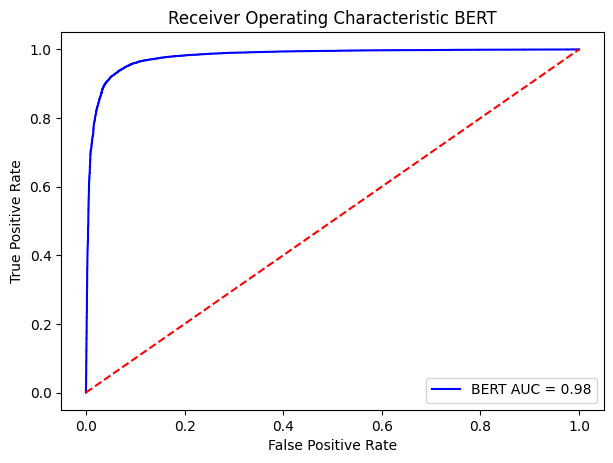

In [35]:
bert_preds = preds_bert_proba[:,1:]
fpr_bert, tpr_bert, _ = metrics.roc_curve(true_labels, bert_preds)
roc_auc_bert = metrics.auc(fpr_bert, tpr_bert)
plt.title('Receiver Operating Characteristic BERT')
plt.plot(fpr_bert, tpr_bert, 'b', label = 'BERT AUC = %0.2f' % roc_auc_bert)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Combined ROC-AUC to compare results

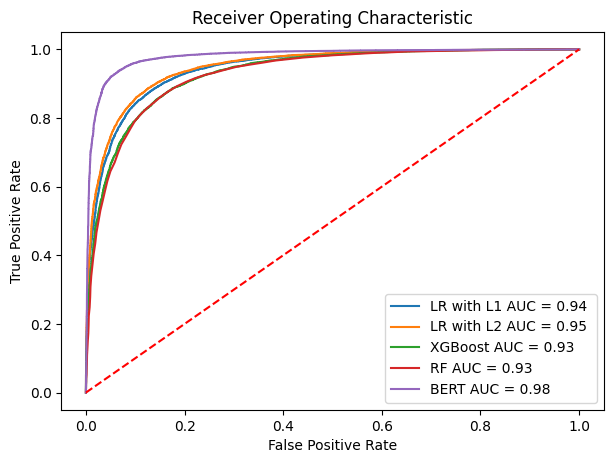

In [53]:
plt.plot(fpr_lr_l1, tpr_lr_l1,  label = 'LR with L1 AUC = %0.2f ' % roc_auc_lr_l1)
plt.plot(fpr_lr_l2, tpr_lr_l2,  label = 'LR with L2 AUC = %0.2f ' % roc_auc_lr_l2)
plt.plot(fpr_xgb, tpr_xgb, label = 'XGBoost AUC = %0.2f' % roc_auc_xgb)
plt.plot(fpr_RF, tpr_RF,  label = 'RF AUC = %0.2f' % roc_RF)
plt.plot(fpr_bert, tpr_bert,  label = 'BERT AUC = %0.2f' % roc_auc_bert)
plt.title('Receiver Operating Characteristic')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

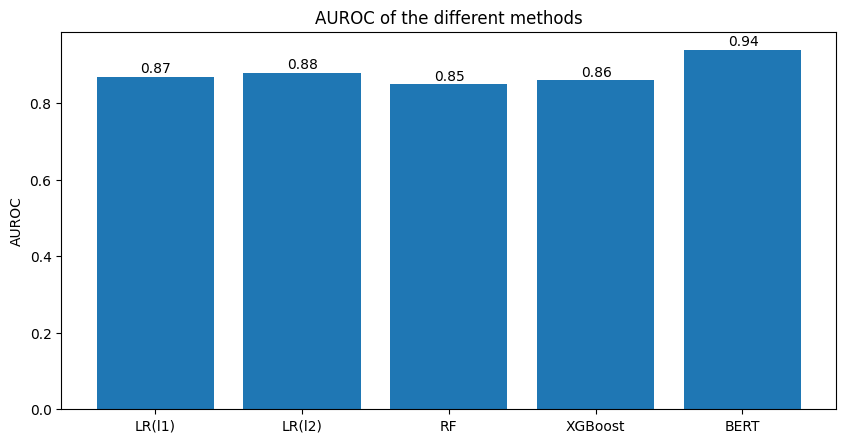

In [57]:
# Summary barplot: (pls add BERT into the bars:)

fig = plt.figure(figsize = (10, 5))
height = [round(acc_lr_l1, 2), round(acc_lr_l2,2), round(acc_rf,2), round(acc_xgboost,2), round(avg_test_accuracy,2)] 
bars = ('LR(l1)','LR(l2)','RF', 'XGBoost', 'BERT')
y_pos = np.arange(len(bars))

# Create bars
plt.bar(y_pos, height)

# Create names on the x-axis
plt.xticks(y_pos, bars)
plt.ylabel("AUROC")
plt.title("AUROC of the different methods")
for i, v in enumerate(height):
    plt.text(y_pos[i] - 0.1, v + 0.01, str(v))
# Show graphic
plt.show()

In [58]:
torch.save(model.state_dict(), "model.pt")

### heatmaps of the attention matrics between words for pos and neg reviews

In [5]:
model.load_state_dict(torch.load("model.pt"))


<All keys matched successfully>

In [24]:
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [191]:
# select a positive review review with a positive 
pos_review = test_data[-4]
# Get input, mask and label
sample_input = pos_review[0][None, :].to(device).long()
sample_mask = pos_review[1][None, :].to(device).long()
sample_labels = pos_review[2][None, :].to(device).long()

In [192]:
with torch.no_grad():        
    output = model(sample_input, 
                            token_type_ids=None, 
                            attention_mask=sample_mask,
                            labels=sample_labels,
                            return_dict = True,
                  output_attentions=True # return attention weights
        )


In [193]:
#Extract attention weights of the last layer for the forth head
last_layer_attention_weights_fourth_head=output['attentions'][11][0][3] 

In [194]:
# We will visualize weights between the first 10 words
# Extract the 10 first words
words = tokenizer.convert_ids_to_tokens(pos_review[0].cpu())[:10]
print(words)

['[CLS]', 'i', 'love', 'this', 'movie', 'like', 'no', 'other', '.', 'another']


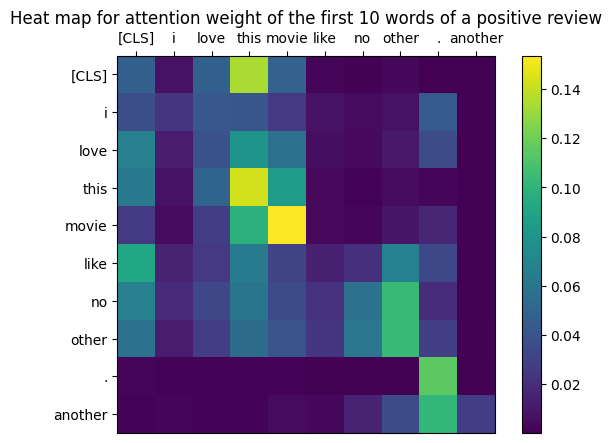

In [195]:
import matplotlib.pyplot as plt
import numpy as np
plt.imshow(np.array(last_layer_attention_weights_fourth_head.cpu())[:10,:10], interpolation='nearest')
plt.colorbar()
xi = list(range(len(words)))
plt.xticks(xi, words,)
plt.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
plt.yticks(xi, words)
plt.title("Heat map for attention weight of the first 10 words of a positive review")
plt.show()


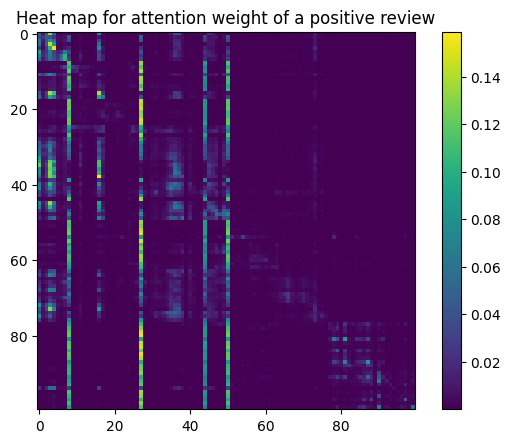

In [196]:
plt.imshow(np.array(last_layer_attention_weights_fourth_head.cpu())[:100,:100], interpolation='nearest')
plt.colorbar()
plt.title("Heat map for attention weight of a positive review")
plt.show()


In [197]:
# select a negative review review with a positive 
neg_review = test_data[30]
# Get input, mask and label
sample_input = neg_review[0][None, :].to(device).long()
sample_mask = neg_review[1][None, :].to(device).long()
sample_labels = neg_review[2][None, :].to(device).long()

In [198]:
with torch.no_grad():        
    output = model(sample_input, 
                            token_type_ids=None, 
                            attention_mask=sample_mask,
                            labels=sample_labels,
                            return_dict = True,
                  output_attentions=True # return attention weights
        )


In [186]:
#Extract attention weights of the last layer for the forth head
last_layer_attention_weights_fourth_head=output['attentions'][11][0][3] 

In [199]:
# We will visualize weights between the first 10 words
# Extract the 10 first words
words = tokenizer.convert_ids_to_tokens(neg_review[0].cpu())[:20]
print(words)

['[CLS]', 'i', 'have', 'not', 'seen', 'many', 'low', 'budget', 'films', 'i', 'must', 'admit', ',', 'but', 'this', 'is', 'the', 'worst', 'movie', 'ever']


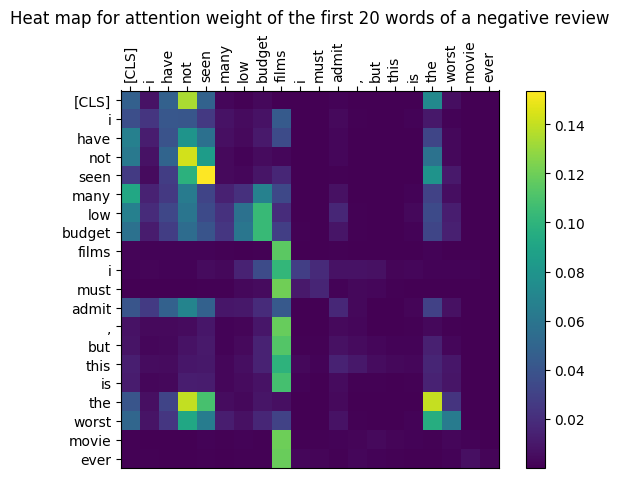

In [200]:
import matplotlib.pyplot as plt
import numpy as np
plt.imshow(np.array(last_layer_attention_weights_fourth_head.cpu())[:20,:20], interpolation='nearest')
plt.colorbar()
xi = list(range(len(words)))
plt.xticks(xi, words,rotation=90)
plt.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
plt.yticks(xi, words)
plt.title("Heat map for attention weight of the first 20 words of a negative review")
plt.show()


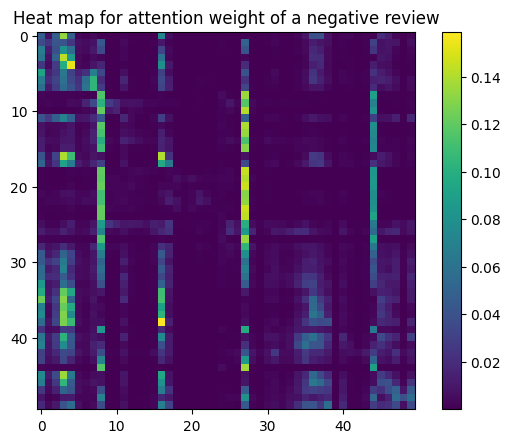

In [201]:
plt.imshow(np.array(last_layer_attention_weights_fourth_head.cpu())[:50,:50], interpolation='nearest')
plt.colorbar()
plt.title("Heat map for attention weight of a negative review")
plt.show()


In [202]:
#END